<a href="https://colab.research.google.com/github/Bookmaster9/image-classification/blob/master/dl_v4_transfer_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import itertools
# install keras tuner package
!pip install -q -U keras-tuner
import kerastuner as kt
# install kaggle package
!pip install -q kaggle

# mount google drive for access to local files if necessary
drive.mount('/content/drive/')
!ls "/content/drive/My Drive"

# generate the api token json file from kaggle account
# upload to drive and then copy
!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/app/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#!kaggle datasets list
# !kaggle datasets download -d andrewmvd/pediatric-pneumonia-chest-xray
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -qq chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX
!rm -rf chest_xray/chest_xray
!find . -print | grep -i '.*[.]jpeg' | wc -l

# datasets for normal, covid-19, pneumonia-viral and pneumonia-baterial; 
# curated more complete than Paul M set; only test normal and pneumonia-bacterial classes
!kaggle datasets download -d unaissait/curated-chest-xray-image-dataset-for-covid19
!unzip -qq curated-chest-xray-image-dataset-for-covid19.zip
!rm curated-chest-xray-image-dataset-for-covid19.zip
!rm -rf Curated\ X-Ray\ Dataset/COVID-19
!rm -rf Curated\ X-Ray\ Dataset/Pneumonia-Viral
!find . -print | grep -i '.*[.]jpg' | wc -l

     |████████████████████████████████| 71kB 8.3MB/s 
Mounted at /content/drive/
'3 18 Weekly Presentation.gslides'
'Answer keys_olympiad chemistry reaction questions_aqueous solution_June 10_2020.pdf'
 app
 Application.gdoc
 chem
'Colab Notebooks'
 college-application
'Complex ions.pdf'
'El conocimiento.gdoc'
'honor code.pdf'
 IMG_5873.MOV
 Lawrence.xlsx
 Other
'problems i need to redo before the test.gdoc'
'Research proposal 2020.docx'
 rsi-app.docx
 rsi-app-v2.docx
'Untitled document (1).gdoc'
'Untitled document (2).gdoc'
'Untitled document (3).gdoc'
'Untitled document (4).gdoc'
'Untitled document.gdoc'
'Untitled folder'
'Untitled presentation (1).gslides'
'Untitled presentation.gslides'
'Untitled spreadsheet.gsheet'
100% 2.29G/2.29G [00:28<00:00, 47.1MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.7MB/s]
5860
100% 3.49G/3.49G [01:26<00:00, 49.6MB/s]
100% 3.49G/3.49G [01:26<00:00, 43.2MB/s]
6280


In [ ]:
""" remove corrupted images and do basic exploratory analysis on datasets """
def preprocess_images(path, img_suffix):
  num_skipped = 0
  img_shape = {}
  file_count = {}

  for root, dirs, files in os.walk(path, topdown = False):
    for dname in dirs:
        dpath = os.path.join(root, dname)
        n_file = 0
        for fname in os.listdir(dpath):
          fullpath = os.path.join(dpath, fname)
          if(fname.find(img_suffix) > 0):
            try:
                fobj = open(fullpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fullpath)
                continue
            else:
              n_file += 1

            img = cv2.imread(fullpath)
            img_shape[fname] = img.shape
        file_count[dpath] = n_file

  for k, v in file_count.items():
    print(k, ' --> ', v)

  # explor image shapes
  sumx = 0
  sumy = 0
  color = 0
  count = 0
  x = []
  y = []

  for k in img_shape:
    sumx += img_shape[k][0]
    sumy += img_shape[k][1]
    color += img_shape[k][2]
    x.append(img_shape[k][0])
    y.append(img_shape[k][1])
    count += 1

  avgx = round(sumx / count)
  avgy = round(sumy / count)
  avgc = round(color / count)

  print("number of currupted images removed = ", num_skipped)
  print('image shape: ', avgx, ' x ', avgy, ' x ', avgc)
  sns.regplot(x=x, y=y, line_kws={'lw': 2, 'color': 'red'})

In [ ]:
def move_files(source, destination):
  for i in os.listdir(source):
      if not os.path.exists(destination):
          shutil.move(os.path.join(source, i), destination)
      else:
          shutil.copy2(os.path.join(source, i), destination)

In [ ]:
""" explore some images before and after augmentation """
def explore_images(path):
  IMAGE_SIZE = (128, 128)
  SEED = 1337

  train_ds = tf.keras.preprocessing.image_dataset_from_directory(path, validation_split=0.2, subset='training', image_size=IMAGE_SIZE, seed=SEED)
  class_names = train_ds.class_names

  # original images
  plt.figure(figsize=(20, 8))
  for images, labels in train_ds.take(1):
    for i in range(10):
      ax = plt.subplot(2, 5, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      # plt.title(int(labels[i]))
      plt.axis("off")

  # data augmentation - flip and rotate some images 
  data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      ]
  )

  # images after augmentations
  plt.figure(figsize=(20, 8))
  for images, labels in train_ds.take(1):
      for i in range(10):
          augmented_images = data_augmentation(images)
          ax = plt.subplot(2, 5, i + 1)
          plt.imshow(augmented_images[0].numpy().astype("uint8"))
          plt.title(class_names[int(labels[i])])
          plt.axis("off")
  plt.show()

In [ ]:
### build a base model
def build_base_model(image_size, num_classes, learning_rate):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=image_size + (3,)))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

  model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

  model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

  model.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(units=128,activation='relu'))
  model.add(tf.keras.layers.Dense(units=64,activation='relu'))

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  model.add(tf.keras.layers.Dense(units,activation=activation))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )
  return model

In [ ]:
def build_augmented_model(image_size, num_classes, learning_rate, regularizer=None):

  data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      ]
  )

  inputs = tf.keras.Input(shape = image_size + (3,))
  model = data_augmentation(inputs)

  model = tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu')(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu')(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu')(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu')(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Flatten()(model)

  if regularizer is None:
    model = tf.keras.layers.Dense(units=128,activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = tf.keras.layers.Dense(units=64,activation='relu')(model)

  elif regularizer.lower() == 'l1':
    model = tf.keras.layers.Dense(units=128,activation='relu', bias_regularizer=tf.keras.regularizers.l1(l=0.01))(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = tf.keras.layers.Dense(units=64,activation='relu', bias_regularizer=tf.keras.regularizers.l1(l=0.01))(model)

  elif regularizer.lower() == 'l2':
    model = tf.keras.layers.Dense(units=128,activation='relu', bias_regularizer=tf.keras.regularizers.l2(l=0.001))(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = tf.keras.layers.Dense(units=64,activation='relu', bias_regularizer=tf.keras.regularizers.l2(l=0.001))(model)

  elif regularizer.lower() == 'l1l2':
    model = tf.keras.layers.Dense(units=128,activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = tf.keras.layers.Dense(units=64,activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(model)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  outputs = tf.keras.layers.Dense(units, activation=activation)(model)
  
  model = tf.keras.Model(inputs, outputs)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model

In [ ]:
def build_tunable_model(hp):

  image_size = (128, 128)
  input_shape = image_size + (3,)
  inputs = tf.keras.Input(shape=input_shape)
  data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
  )
  x = data_augmentation(inputs)

  for i in range(hp.Int('conv_blocks', 3, 5, default = 3)):
    filters = hp.Int('flters_' + str(i), 32, 256, step=32)
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, activation='relu', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(x)

  x = tf.keras.layers.Flatten()(x)

  for j in range(hp.Int('dense_blocks', 1, 2, default = 2)):
    dense_layers = hp.Int('dense_' + str(j), 32, 128, step=32, default=64)
    x = tf.keras.layers.Dense(dense_layers, activation='relu')(x)
    x = tf.keras.layers.Dropout(
        hp.Float('dropout', 0.0, 0.5, step=0.1, default = 0.2))(x)

  outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs, outputs)

  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Choice('learning_rate', values = [1e-6, 1e-5, 1e-4])),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  return model


In [ ]:
def tune_model(train_ds, val_ds, class_weights):
  tuner = kt.Hyperband(
      build_tunable_model,
      objective='val_accuracy',
      max_epochs=10,
      hyperband_iterations=2,
      overwrite=True)

  tuner.search(train_ds,
              validation_data=val_ds,
              class_weight = class_weights,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

  best_model = tuner.get_best_models(1)[0]

  return best_model

In [ ]:
def build_tuned_model(image_size, num_classes, learning_rate):

  data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      ]
  )

  inputs = tf.keras.Input(shape = image_size + (3,))
  model = data_augmentation(inputs)

  model = tf.keras.layers.Conv2D(filters=160,kernel_size=3,activation='relu', padding = 'same')(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu', padding = 'same')(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=192,kernel_size=3,activation='relu',padding = 'same')(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Conv2D(filters=160,kernel_size=3,activation='relu',padding = 'same')(model)
  model = tf.keras.layers.BatchNormalization()(model)
  model = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(model)

  model = tf.keras.layers.Flatten()(model)

  model = tf.keras.layers.Dense(units=96,activation='relu')(model)
  model = tf.keras.layers.Dropout(0.3)(model)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  outputs = tf.keras.layers.Dense(units, activation=activation)(model)
  
  model = tf.keras.Model(inputs, outputs)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )

  return model

In [ ]:
def train_base_model(model, train_ds, val_ds, epochs, save_model_fname):

  callbacks = [
      tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
  ]

  history = model.fit(
      train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
  )

  model.save(save_model_fname)

  return history

In [ ]:
def train_weighted_model(model, train_ds, val_ds, epochs, save_model_fname, class_weights):

  callbacks = [
      tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
  ]

  history = model.fit(
      train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, class_weight=class_weights
  )

  model.save(save_model_fname)

  return history

In [ ]:
def train_weighted_model_es(model, train_ds, val_ds, epochs, save_model_fname, class_weights):

  earlystop_callbacks = [
      tf.keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      min_delta=0.00005,
      patience=3)
  ]

  history = model.fit(
      train_ds, epochs=epochs, callbacks = earlystop_callbacks, validation_data=val_ds, class_weight=class_weights
  )

  model.save(save_model_fname)

  return history

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy vs. No. of epochs')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()  

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss vs. No of epochs')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

In [ ]:
def predict_image(model_path, image_path, image_size=(128, 128)):
  CATEGORIES = ['Normal', 'Pneumonia']

  img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  loaded_model = tf.keras.models.load_model(model_path)
  predictions = loaded_model.predict(img_array)
  score = predictions[0]

  print(
      "This image is %.2f percent NORMAL and %.2f percent PNEUMONIA."
      % (100 * (1-score), 100 * score)
  )

  return CATEGORIES[(predictions[0][0] > 0.5).astype("int32")]

In [ ]:
def predict_batch(model_path, folder_path, predict_class, image_size=(128, 128)):
 
  # load the trained model
  model = tf.keras.models.load_model(model_path)

  images = []
  num_images = 0

  for img in os.listdir(folder_path):
    num_images += 1
    img = os.path.join(folder_path, img)
    img = tf.keras.preprocessing.image.load_img(img, target_size=image_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

  images = np.vstack(images)
  predictions = model.predict(images, batch_size=10)
  classes = (predictions[:,0] > 0.5).astype("int32")

  num_correct = int(sum(classes))
  
  if(predict_class == 0):
    num_correct = num_images - num_correct

  print("number of images in the path = ", num_images)
  print("number of images classified correctly = ", num_correct)
  print("classification accuracy = %.2f percent" % round(100 * (num_correct/num_images), 2))

  return round(100 * (num_correct/num_images), 2)


In [ ]:
def get_confusion_matrix(model_path, test_data_path, image_size=(128, 128)):

  model = tf.keras.models.load_model(model_path)
  
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
  test_data_generator = test_generator.flow_from_directory(
      test_data_path,
      target_size=image_size,
      batch_size=2,
      shuffle=False)
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

  predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch, verbose=1, workers=0)

  predicted_classes = np.where(predictions>0.5, 1, 0)

  true_classes = test_data_generator.classes

  class_labels = list(test_data_generator.class_indices.keys())

  report = sm.classification_report(true_classes, predicted_classes, target_names=class_labels)
  print(report)

  cm = sm.confusion_matrix(true_classes, predicted_classes)

  return cm

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='YlGnBu'):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: # normalized cm
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class label')
    plt.xlabel('Predicted class label')
    plt.show()

In [ ]:
def plot_cm(pred_matrix, classes):
  fig, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(pred_matrix, annot=True, fmt='g', linewidth=0.5, square=True,  cmap="YlGnBu", ax=ax, xticklabels=classes, yticklabels=classes)
  plt.ylabel('True class label')
  plt.xlabel('Predicted class label')
  plt.show()

In [ ]:
def plot_roc(model_path, test_data_path, image_size=(128, 128)):

  model = tf.keras.models.load_model(model_path)
  
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
  test_data_generator = test_generator.flow_from_directory(
      test_data_path,
      target_size=image_size,
      batch_size=2,
      shuffle=False)
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

  predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch, verbose=1, workers=0)

  # predicted_classes = np.where(predictions>0.5, 1, 0)
  # class_labels = list(test_data_generator.class_indices.keys())

  true_classes = test_data_generator.classes

  fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, predictions)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.plot(fpr_keras, tpr_keras, color='darkorange', label='ROC curve (area = %0.2f)' % auc_keras)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")
  plt.show()


In [ ]:
def build_xception_model(image_size, learning_rate = 1e-5):

  data_augmentation = tf.keras.Sequential(
      [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      ]
  )

  base_model = tf.keras.applications.Xception(
      weights = "imagenet",  # Load weights pre-trained on ImageNet.
      input_shape = image_size + (3,),
      include_top = False,
  )

  # Freeze the base_model
  base_model.trainable = False

  # Create new model on top
  inputs = tf.keras.Input(shape = image_size + (3,))
  x = data_augmentation(inputs)
  # x = keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)

  # Pre-trained Xception weights require that input be normalized from (0, 255) to a range (-1., +1.)
  norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
  mean = np.array([127.5] * 3)
  var = mean ** 2
  # Scale inputs to [-1, +1]
  x = norm_layer(x)
  norm_layer.set_weights([mean, var])

  # The base model contains batchnorm layers. We want to keep them in inference mode
  x = base_model(x, training = False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  # add a fully connected layer and regularize with dropout
  x = tf.keras.layers.Dense(units = 96, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(0.3)(x)

  # binary classifier output
  outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs, outputs)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.BinaryAccuracy()],
  )

  return (base_model, model)

In [ ]:
def train_xception_model(base_model, model, train_ds, val_ds, save_model_fname, class_weights, initial_epochs=20, fine_tune_epochs=10, learning_rate=1e-5):

  # first pass with base model bottom layers frozen
  history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds, class_weight=class_weights)

  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Unfreeze the base_model
  base_model.trainable = True
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Low learning rate
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.BinaryAccuracy()],
  )

  # fine tune the model
  total_epochs = initial_epochs + fine_tune_epochs
  history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val_ds, class_weight=class_weights)

  acc += history_fine.history['binary_accuracy']
  val_acc += history_fine.history['val_binary_accuracy']

  loss += history_fine.history['loss']
  val_loss += history_fine.history['val_loss']

  # save the model
  model.save(save_model_fname)

  return (acc, val_acc, loss, val_loss)

In [ ]:
def plot_acc_loss (acc, val_acc, loss, val_loss, initial_epochs):

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0.8, 1])
  plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylim([0, 1.0])
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
def plot_rocs(models, test_data_path, image_size=(128,128)):

  # load test dataset
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
  test_data_generator = test_generator.flow_from_directory(
      test_data_path,
      target_size=image_size,
      batch_size=2,
      shuffle=False)
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

  # Below for loop iterates through models list
  plt.figure()

  for m in models:

    # select and load the model
    model_path = m['model']
    model = tf.keras.models.load_model(model_path)

    predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch, verbose=1, workers=0)

    true_classes = test_data_generator.classes

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, predictions)
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.plot(fpr_keras, tpr_keras, label='%s ROC (area = %0.2f)' % (m['label'], auc_keras))

  # parameters for entire plot
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('1-Specificity (False Positive Rate)')
  plt.ylabel('Sensitivity (True Positive Rate)')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="lower right")
  plt.show()   # Display

./chest_xray/train/PNEUMONIA  -->  3743
./chest_xray/train/NORMAL  -->  1300
./chest_xray/val/PNEUMONIA  -->  8
./chest_xray/val/NORMAL  -->  2
./chest_xray/test/PNEUMONIA  -->  352
./chest_xray/test/NORMAL  -->  234
./chest_xray/train  -->  0
./chest_xray/val  -->  0
./chest_xray/test  -->  0
number of currupted images removed =  217
image shape:  967  x  1325  x  3
./Curated X-Ray Dataset/Pneumonia-Bacterial  -->  3001
./Curated X-Ray Dataset/Normal  -->  3270
number of currupted images removed =  0
image shape:  884  x  1112  x  3
83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
__________________________________________________

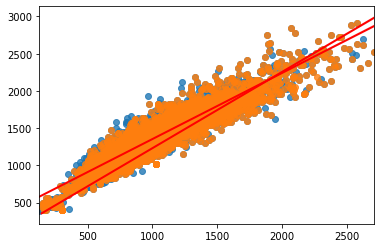

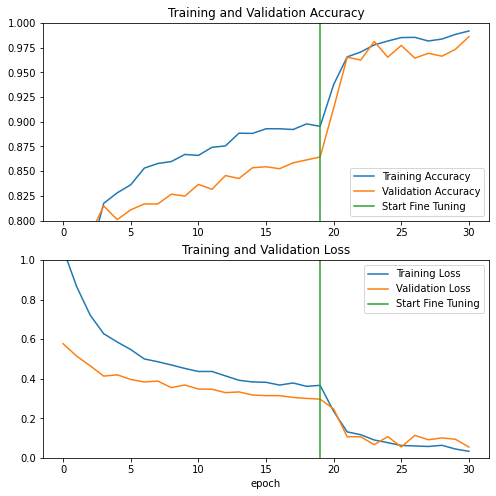

19/19 [==============================] - 4s 141ms/step - loss: 0.8667 - binary_accuracy: 0.8362
Test accuracy : 0.8361774682998657


In [ ]:
# image file clean up
preprocess_images('./chest_xray', '.jpeg')
preprocess_images('./Curated X-Ray Dataset', '.jpg')

# combine files from validation dir to training dir
move_files('chest_xray/val/NORMAL', 'chest_xray/train/NORMAL')
move_files('chest_xray/val/PNEUMONIA', 'chest_xray/train/PNEUMONIA')

image_size = (128, 128)
vsplit = 0.2
seed = 1337
class_weights = {0: 2.88, 1: 1.00}
initial_epochs = 20
fine_tune_epochs = 10
save_model_fname = 'drive/My Drive/app/xray/xray-model-transfer-balance-def.h5'

# build a model based on xception
base_model, model = build_xception_model(image_size, learning_rate = 1e-5)
model.summary()

train_ds = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train', validation_split=vsplit, subset='training', seed=seed, image_size=image_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train', validation_split=vsplit, subset='validation', seed=seed, image_size=image_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/test', image_size=image_size)

# train and fine tune the model
acc, val_acc, loss, val_loss = train_xception_model(
    base_model, model, train_ds, val_ds, save_model_fname, class_weights, initial_epochs=initial_epochs, fine_tune_epochs=fine_tune_epochs, learning_rate=1e-5)

# plot the model accuracy and loss
plot_acc_loss (acc, val_acc, loss, val_loss, initial_epochs)

# evaluate the test ds
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

Found 586 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  1/293 [..............................] - ETA: 31s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 5s 18ms/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 6s 19ms/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 8s 24ms/step


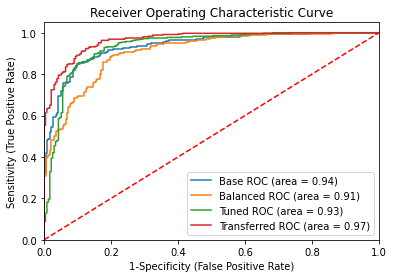

In [ ]:
# image file clean up
# preprocess_images('./chest_xray', '.jpeg')
# preprocess_images('./Curated X-Ray Dataset', '.jpg')

# combine files from validation dir to training dir
# move_files('chest_xray/val/NORMAL', 'chest_xray/train/NORMAL')
# move_files('chest_xray/val/PNEUMONIA', 'chest_xray/train/PNEUMONIA')

image_size = (128, 128)

models = [
  {
      'label': 'Base',
      'model': 'drive/My Drive/app/xray/xray-model-v1-def.h5',
  },
  {
      'label': 'Augmented',
      'model': 'drive/My Drive/app/xray/xray-model-v2-def.h5',
  },
  {
      'label': 'Tuned',
      'model': 'drive/My Drive/app/xray/xray-model-tuned-def.h5',
  },
  {
      'label': 'Transferred',
      'model': 'drive/My Drive/app/xray/xray-model-transfer-balance-def.h5',
  }
]

test_data_path = "chest_xray/test"
# test_data_path = "Curated X-Ray Dataset"

plot_rocs(models, test_data_path, image_size=image_size)


Found 586 images belonging to 2 classes.
  1/293 [..............................] - ETA: 33s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  1/293 [..............................] - ETA: 37s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 6s 20ms/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 8s 25ms/step


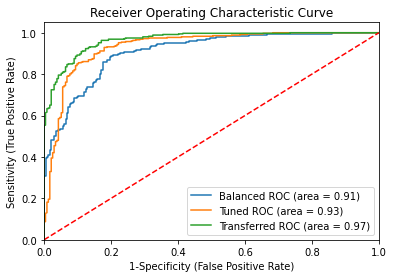

In [ ]:
# # image file clean up
# preprocess_images('./chest_xray', '.jpeg')
# preprocess_images('./Curated X-Ray Dataset', '.jpg')

# # combine files from validation dir to training dir
# move_files('chest_xray/val/NORMAL', 'chest_xray/train/NORMAL')
# move_files('chest_xray/val/PNEUMONIA', 'chest_xray/train/PNEUMONIA')

image_size = (128, 128)

models = [
  {
      'label': 'Augmented',
      'model': 'drive/My Drive/app/xray/xray-model-v2-def.h5',
  },
  {
      'label': 'Tuned',
      'model': 'drive/My Drive/app/xray/xray-model-tuned-def.h5',
  },
  {
      'label': 'Transferred',
      'model': 'drive/My Drive/app/xray/xray-model-transfer-balance-def.h5',
  }
]

test_data_path = "chest_xray/test"
# test_data_path = "Curated X-Ray Dataset"

plot_rocs(models, test_data_path, image_size=image_size)

Found 586 images belonging to 2 classes.
  1/293 [..............................] - ETA: 31s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


  1/293 [..............................] - ETA: 29s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 6s 19ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 9s 26ms/step


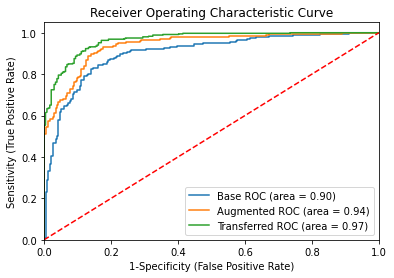

In [ ]:
# image file clean up
# preprocess_images('./chest_xray', '.jpeg')
# preprocess_images('./Curated X-Ray Dataset', '.jpg')

# # combine files from validation dir to training dir
# move_files('chest_xray/val/NORMAL', 'chest_xray/train/NORMAL')
# move_files('chest_xray/val/PNEUMONIA', 'chest_xray/train/PNEUMONIA')

image_size = (128, 128)

models = [
  {
      'label': 'Base',
      'model': 'drive/My Drive/app/xray/xray-model-v1-def.h5',
  },
  {
      'label': 'Augmented',
      'model': 'drive/My Drive/app/xray/xray-model-augmented-def.h5',
  },
  {
      'label': 'Transferred',
      'model': 'drive/My Drive/app/xray/xray-model-transfer-balance-def.h5',
  }
]

test_data_path = "chest_xray/test"
# test_data_path = "Curated X-Ray Dataset"

plot_rocs(models, test_data_path, image_size=image_size)

Found 6271 images belonging to 2 classes.
   1/3136 [..............................] - ETA: 4:01

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


   1/3136 [..............................] - ETA: 5:05

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3136/3136 [==============================] - 130s 41ms/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3136/3136 [==============================] - 151s 48ms/step


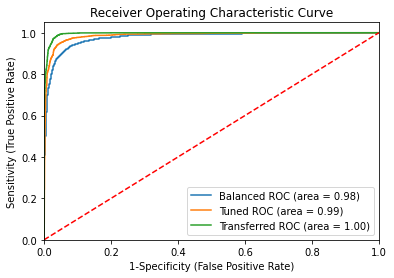

In [ ]:
# # image file clean up
# preprocess_images('./chest_xray', '.jpeg')
# preprocess_images('./Curated X-Ray Dataset', '.jpg')

# # combine files from validation dir to training dir
# move_files('chest_xray/val/NORMAL', 'chest_xray/train/NORMAL')
# move_files('chest_xray/val/PNEUMONIA', 'chest_xray/train/PNEUMONIA')

image_size = (128, 128)

models = [
  {
      'label': 'Augmented',
      'model': 'drive/My Drive/app/xray/xray-model-v2-def.h5',
  },
  {
      'label': 'Tuned',
      'model': 'drive/My Drive/app/xray/xray-model-tuned-def.h5',
  },
  {
      'label': 'Transferred',
      'model': 'drive/My Drive/app/xray/xray-model-transfer-balance-def.h5',
  }
]

# test_data_path = "chest_xray/test"
test_data_path = "Curated X-Ray Dataset"

plot_rocs(models, test_data_path, image_size=image_size)

Found 6271 images belonging to 2 classes.
   1/3136 [..............................] - ETA: 4:02

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


   1/3136 [..............................] - ETA: 4:07

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3136/3136 [==============================] - 129s 41ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3136/3136 [==============================] - 156s 50ms/step


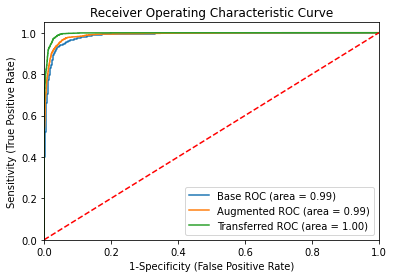

In [ ]:
# # image file clean up
# preprocess_images('./chest_xray', '.jpeg')
# preprocess_images('./Curated X-Ray Dataset', '.jpg')

# # combine files from validation dir to training dir
# move_files('chest_xray/val/NORMAL', 'chest_xray/train/NORMAL')
# move_files('chest_xray/val/PNEUMONIA', 'chest_xray/train/PNEUMONIA')

image_size = (128, 128)

models = [
  {
      'label': 'Base',
      'model': 'drive/My Drive/app/xray/xray-model-v1-def.h5',
  },
  {
      'label': 'Augmented',
      'model': 'drive/My Drive/app/xray/xray-model-augmented-def.h5',
  },
  {
      'label': 'Transferred',
      'model': 'drive/My Drive/app/xray/xray-model-transfer-balance-def.h5',
  }
]

# test_data_path = "chest_xray/test"
test_data_path = "Curated X-Ray Dataset"

plot_rocs(models, test_data_path, image_size=image_size)

Found 586 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


293/293 [==============================] - 9s 28ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.61      0.75       234
   PNEUMONIA       0.79      0.99      0.88       352

    accuracy                           0.84       586
   macro avg       0.89      0.80      0.82       586
weighted avg       0.87      0.84      0.83       586



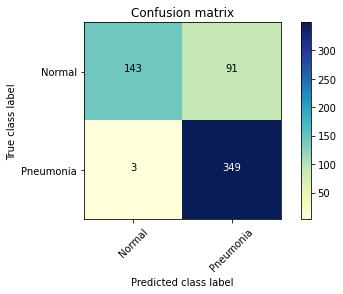

In [ ]:
model_path = 'drive/My Drive/app/xray/xray-model-transfer-balance-def.h5'
test_data_path = "chest_xray/test"
cm = get_confusion_matrix(model_path, test_data_path, image_size=(128, 128))
classes = ['Normal', 'Pneumonia']
plot_confusion_matrix(cm, classes)

Found 6271 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3136/3136 [==============================] - 155s 49ms/step
                     precision    recall  f1-score   support

             Normal       0.99      0.95      0.97      3270
Pneumonia-Bacterial       0.95      0.99      0.97      3001

           accuracy                           0.97      6271
          macro avg       0.97      0.97      0.97      6271
       weighted avg       0.97      0.97      0.97      6271



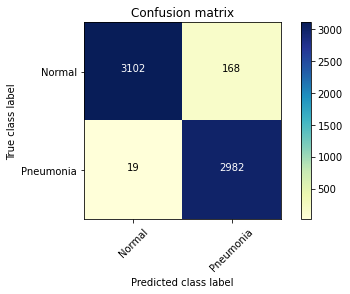

In [ ]:
model_path = 'drive/My Drive/app/xray/xray-model-transfer-balance-def.h5'
test_data_path = "Curated X-Ray Dataset"
cm = get_confusion_matrix(model_path, test_data_path, image_size=(128, 128))
classes = ['Normal', 'Pneumonia']
plot_confusion_matrix(cm, classes)